# Generating margins in `from_dataframe`

We are now able to generate margins for a catalog created from a CSV file.

In [1]:
import lsdb
import numpy as np
import pandas as pd

First we load a small sky source catalog to a Pandas DataFrame:

In [2]:
small_sky_source_csv = "/astro/users/smcampos/small_sky_source.csv"
small_sky_source_df = pd.read_csv(small_sky_source_csv)
small_sky_source_df

,source_id,source_ra,source_dec,mjd,mag,band,object_id,object_ra,object_dec
0,70000,301.927172,-59.438686,58363.286356,17.104989,z,810,301.5,-59.5
1,70001,305.920293,-59.907292,58363.380619,17.586861,i,716,305.5,-60.5
2,70002,303.823213,-43.372721,58363.422318,20.557382,u,717,303.5,-43.5
3,70003,337.807437,-38.361372,58363.586547,18.673041,z,745,337.5,-38.5
4,70004,320.566223,-53.451949,58363.654246,18.840165,g,760,320.5,-53.5
...,...,...,...,...,...,...,...,...,...
17156,87156,335.733501,-68.952632,59562.482971,15.090752,i,826,335.5,-69.5
17157,87157,320.540038,-69.270556,59562.587765,18.990507,r,792,320.5,-69.5
17158,87158,327.535831,-51.379757,59562.638550,16.450693,g,762,327.5,-51.5
17159,87159,303.553419,-37.935144,59562.754894,20.616895,y,755,303.5,-38.5


When calling `from_dataframe` we can now specify *margin_order* and *margin_threshold*, in arcseconds, to control the margin cache generation. By default the margin order is the order of the catalog + 1, and the threshold distance is 5 arcseconds.

In [3]:
small_sky_source = lsdb.from_dataframe(
    small_sky_source_df,
    catalog_name="small_sky_source",
    ra_column="source_ra",
    dec_column="source_dec",
    lowest_order=3,
    highest_order=3,
    margin_order=8,
    margin_threshold=180,
)

In [4]:
small_sky_source

,source_id,source_ra,source_dec,mjd,mag,band,object_id,object_ra,object_dec,Norder,Dir,Npix
npartitions=43,,,,,,,,,,,,
4755801206503243776,int64,float64,float64,float64,float64,string,int64,float64,float64,uint8,uint64,uint64
12736179746203762688,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
13690942867206307840,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
small_sky_source.margin

,source_id,source_ra,source_dec,mjd,mag,band,object_id,object_ra,object_dec,margin_Norder,margin_Dir,margin_Npix,Norder,Dir,Npix
npartitions=32,,,,,,,,,,,,,,,
4755801206503243776,int64,float64,float64,float64,float64,string,int64,float64,float64,uint8,uint64,uint64,uint8,uint64,uint64
12736179746203762688,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13690942867206307840,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


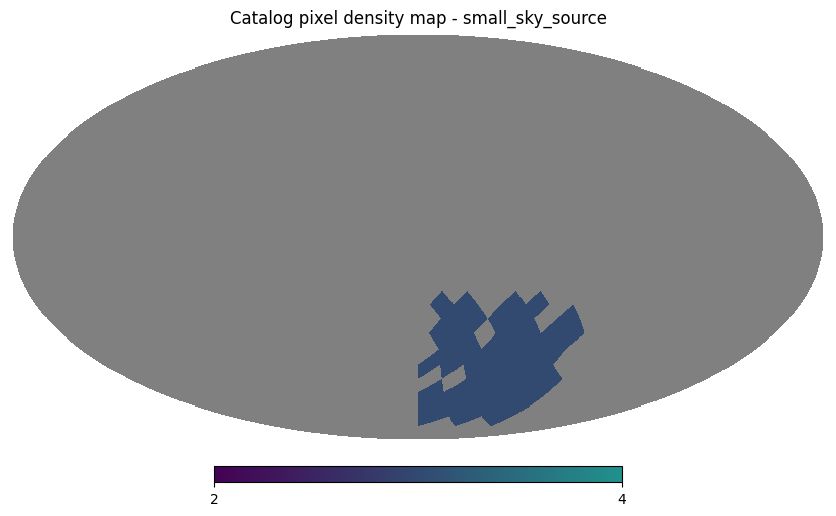

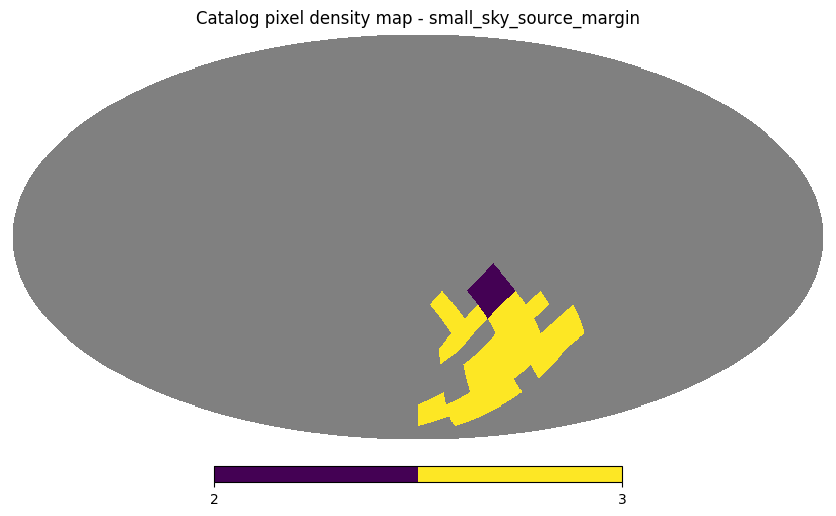

In [6]:
plot_pixels(small_sky_source.hc_structure)
plot_pixels(small_sky_source.margin.hc_structure)

### Comparing with the output of _hipscat-import_

In [7]:
import hipscat_import.margin_cache.margin_cache as mc
import hipscat_import.catalog.run_import as runner
from hipscat_import.margin_cache.margin_cache_arguments import MarginCacheArguments
from hipscat_import.catalog.arguments import ImportArguments

First let's import the source catalog and verify that it is similar to the one generated by `from_dataframe`:

In [8]:
from dask.distributed import Client

import_args = ImportArguments(
    output_path=".",
    output_artifact_name="small_sky_source_importer",
    input_file_list=[small_sky_source_csv],
    file_reader="csv",
    ra_column="source_ra",
    dec_column="source_dec",
    constant_healpix_order=3,
    progress_bar=False,
    overwrite=True,
)

with Client(n_workers=4, memory_limit="auto") as client:
    runner.run(import_args, client)

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35787 instead
  warnings.warn(


In [9]:
small_sky_source_importer = lsdb.read_hipscat("small_sky_source_importer")

# The HEALPix on the two source catalogs match
assert np.array_equal(
    small_sky_source_importer.get_ordered_healpix_pixels(),
    small_sky_source.get_ordered_healpix_pixels(),
)

# And so do their data points
pd.testing.assert_frame_equal(
    small_sky_source_importer.compute().sort_index(),
    small_sky_source.compute().sort_index(),
    check_like=True,
)

And now we can run the margin cache generation with the importer and make sure it also matches the one generated by `from_dataframe`:

In [10]:
margin_cache_args = MarginCacheArguments(
    output_path=".",
    output_artifact_name="small_sky_source_margin_importer",
    input_catalog_path="small_sky_source_importer",
    margin_order=8,
    margin_threshold=180,
    progress_bar=False,
    overwrite=True,
)

with Client(n_workers=4, memory_limit="auto") as client:
    mc.generate_margin_cache(margin_cache_args, client)

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41907 instead
  warnings.warn(


In [11]:
small_sky_source_margin_importer = lsdb.read_hipscat("small_sky_source_margin_importer")

# The HEALPix on the two margin catalogs match
assert np.array_equal(
    small_sky_source_margin_importer.get_ordered_healpix_pixels(),
    small_sky_source.margin.get_ordered_healpix_pixels(),
)

# And so do their data points
for pixel in small_sky_source_margin_importer.get_healpix_pixels():
    partition_1 = small_sky_source_margin_importer.get_partition(pixel.order, pixel.pixel)
    partition_2 = small_sky_source.margin.get_partition(pixel.order, pixel.pixel)
    pd.testing.assert_frame_equal(
        partition_1.compute().sort_index(),
        partition_2.compute().sort_index(),
        check_like=True
    )